In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

from os.path import exists

import read_config_utils as cu

import matplotlib as mpl

In [2]:
input_dir = 'output-files-bootstrap-test6b-6d-1b'


with open( '%s/train-and-true-samples.npy' % input_dir, 'rb') as f :
    train_pts = np.load(f)
    train_det_pts = np.load(f)
    true_pts = np.load(f)
    true_det_pts = np.load(f)
    
print('\n\n')
print(' shape of train_pts:  %s' % str(train_pts.shape))
print(' shape of true_pts:   %s' % str(true_pts.shape))
print('\n\n')






 shape of train_pts:  (4000000, 6)
 shape of true_pts:   (400000, 6)





In [3]:
config_file = '%s/config.txt' % (input_dir)

if not exists(config_file) :
    
    print("\n\n\n ******* Input file does not exist: %s\n\n\n" % config_file )
    sys.exit()
    

In [4]:
ndim = int(cu.get_par( config_file, "ndim"))
print("\n\n Number of feature dimensions: %d\n\n" % ndim)



 Number of feature dimensions: 6




In [5]:
with open( '%s/config-pars.npy' % input_dir, 'rb') as f :
    train_mu = np.load(f, allow_pickle=True )
    train_rho = np.load(f, allow_pickle=True)
    train_sig = np.load(f, allow_pickle=True)    
    true_mu = np.load(f, allow_pickle=True )
    true_rho = np.load(f, allow_pickle=True)
    true_sig = np.load(f, allow_pickle=True)  
    resolution = np.load(f, allow_pickle=True)

<function matplotlib.pyplot.show(close=None, block=None)>

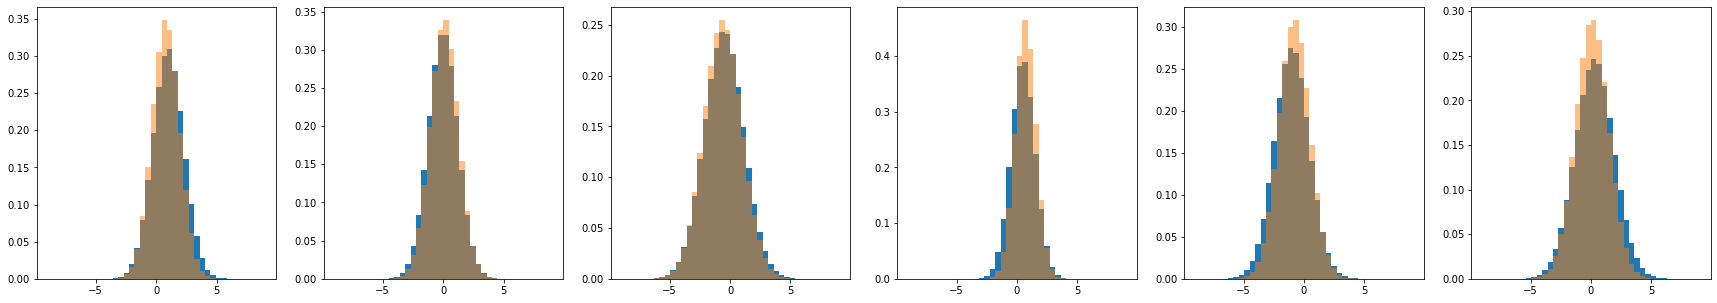

In [6]:
fig,ax = plt.subplots( 1, ndim, figsize=(5*ndim,5))



hmin=-5
hmax=5


hmin=-9
hmax=9

hbins=40


for i in range(ndim) :
        ax[i].hist( train_det_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        ax[i].hist( true_det_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

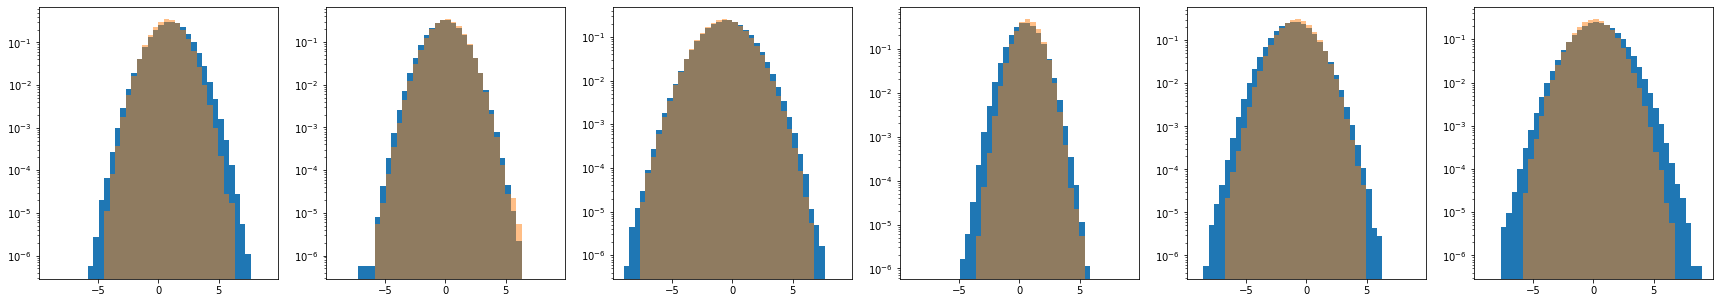

In [7]:
fig,ax = plt.subplots( 1, ndim, figsize=(5*ndim,5))

hbins=40


for i in range(ndim) :
        ax[i].hist( train_det_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        ax[i].hist( true_det_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
        ax[i].set_yscale('log')
    
plt.show

In [8]:
with open( "%s/omnifold-output-weights.npy" % input_dir,'rb') as f :
    main_sample_omnifold_weights = np.load(f)


<function matplotlib.pyplot.show(close=None, block=None)>

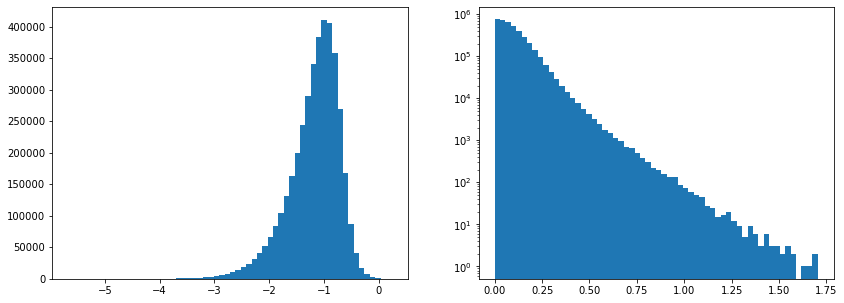

In [9]:
fig,ax = plt.subplots( 1, 2, figsize=(2*7,5))

hbins = 60
ax[0].hist( np.log10(main_sample_omnifold_weights), bins=hbins)
ax[1].hist( main_sample_omnifold_weights, bins=hbins)
ax[1].set_yscale('log')
plt.show

In [10]:
true_rho

array([list([0.0, 0.1, -0.2, 0.2, 0.0]), list([0.0, 0.2, -0.1, 0.0]),
       list([0.4, -0.3, 0.0]), list([0.0, 0.2]), list([0.5])],
      dtype=object)

In [11]:
true_mu.shape

(6,)

In [12]:
true_cov = np.zeros( shape=(ndim,ndim) )

for i in range(ndim) :
    for j in range(ndim) :
        k = ndim - j - 1
        if i == j :
            true_cov[i][j] = true_sig[i]*true_sig[i]
        elif j > i :
            print(" %d, %d, %d" % (i,j,k))
            true_cov[i][j] = true_rho[i][k] * true_sig[i] * true_sig[j]

 0, 1, 4
 0, 2, 3
 0, 3, 2
 0, 4, 1
 0, 5, 0
 1, 2, 3
 1, 3, 2
 1, 4, 1
 1, 5, 0
 2, 3, 2
 2, 4, 1
 2, 5, 0
 3, 4, 1
 3, 5, 0
 4, 5, 0


In [13]:
true_cov

array([[ 0.64 ,  0.   ,  0.16 , -0.096,  0.08 ,  0.   ],
       [ 0.   ,  0.36 ,  0.   , -0.036,  0.12 ,  0.   ],
       [ 0.   ,  0.   ,  1.   ,  0.   , -0.3  ,  0.44 ],
       [ 0.   ,  0.   ,  0.   ,  0.36 ,  0.12 ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.55 ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  1.21 ]])

In [14]:
have_fits = False

if exists( "%s/fit-results.npy" % input_dir ) :
    have_fits = True
    print("\n\n Have fit results file.\n\n")



 Have fit results file.




In [15]:
if have_fits :
    
    with open( '%s/fit-results.npy' % input_dir, 'rb' ) as f :
        fit_results_mean_val = np.load(f, allow_pickle=True )
        fit_results_mean_err = np.load(f, allow_pickle=True )
        fit_results_cov_val = np.load(f, allow_pickle=True )
        fit_results_cov_err = np.load(f, allow_pickle=True )        
        

    ave_fit_err_mean = np.zeros( ndim )

    for fi in range(ndim) :
    
        ave_fit_err_mean[fi] = np.mean( fit_results_mean_err[fi,:])
    

In [16]:
def calc_mean( weights, fi ) :
    
    mean = ( np.sum( weights * train_pts[:,fi]) ) / ( np.sum( weights ) )
    
    return mean

In [17]:
def calc_rms( weights, fi ) :
    
    x = calc_mean( weights, fi )
    xx = ( np.sum( weights * train_pts[:,fi] * train_pts[:,fi] ) ) / ( np.sum( weights ) )
    
    #print(" x = %f,  xx = %f" % (x, xx))
    
    return np.sqrt(xx - x*x)


In [18]:
def calc_cov( weights, fi1, fi2 ) :
    
    x1 = calc_mean( weights, fi1 )
    x2 = calc_mean( weights, fi2 )
    x1x2 = ( np.sum( weights * train_pts[:,fi1] * train_pts[:,fi2] ) ) / ( np.sum( weights ) )
    
    return np.sqrt( x1x2 - x1*x2 )
    

In [19]:
def calc_mean_cov( weights, fi1, fi2 ) :

    return_dict = {}
    
    wsum = np.sum( weights )
    
    wx1 = np.sum( weights * train_pts[:,fi1] )
    wx2 = np.sum( weights * train_pts[:,fi2] )
    wx1x2 = np.sum( weights * train_pts[:,fi1] * train_pts[:,fi2] )

    x1 = wx1 / wsum
    x2 = wx2 / wsum

    x1x2 = wx1x2 / wsum
    
    cov12 = x1x2 - x1*x2

    
    return_dict["mean_x1"] = x1
    return_dict["mean_x2"] = x2
    return_dict["cov_x1x2"] = cov12    
    
    if fi1 != fi2 :
        wx1x1 = np.sum( weights * train_pts[:,fi1] * train_pts[:,fi1] )
        wx2x2 = np.sum( weights * train_pts[:,fi2] * train_pts[:,fi2] )
        cov11 = wx1x1 / wsum - x1*x1
        cov22 = wx2x2 / wsum - x2*x2

        rms1 = np.sqrt(cov11)
        rms2 = np.sqrt(cov22)
        rho12 = cov12 / (rms1*rms2)     
    
        return_dict["rho12"] = rho12
        return_dict["rms1"] = rms1
        return_dict["rms2"] = rms2
    else :
        rms1 = np.sqrt(cov12)
        return_dict["rms1"] = rms1
        
    return return_dict


    

In [20]:
n_samples = 0

for fi in range(1000) :
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, fi)
    
    if exists(fname) :
        n_samples = n_samples + 1
        
print("\n\n Found %d bootstrap samples.\n\n" % n_samples )



 Found 50 bootstrap samples.




In [21]:
%%time

all_mean = np.zeros( shape=(ndim,n_samples) )
all_rms = np.zeros( shape=(ndim,n_samples) )
all_cov = np.zeros( shape=(ndim,ndim,n_samples) )
all_rho = np.zeros( shape=(ndim,ndim,n_samples) )

all_weight_min = np.zeros( n_samples )
all_weight_max = np.zeros( n_samples )


si = 0

for fi in range(200) :
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, fi)
    
    if exists(fname) :
        
        print('\n----- %s exists' % fname )
        
        with open(fname,'rb') as f :
            
            final_push_weights_scaled = np.load(f)
            print( len(final_push_weights_scaled))
            print( final_push_weights_scaled )
            print( true_pts[:,0])
            
            all_weight_min[si] = np.min( final_push_weights_scaled )
            all_weight_max[si] = np.max( final_push_weights_scaled )
            
            for fi1 in range(ndim) :
                for fi2 in range(fi1,ndim) :
                    mean_cov = calc_mean_cov( final_push_weights_scaled, fi1, fi2 )
                    all_cov[fi1,fi2,si] = mean_cov["cov_x1x2"]
                    all_cov[fi2,fi1,si] = mean_cov["cov_x1x2"]
                    if ( fi1 == fi2 ) :
                        print( "  %d %d  :  mean = %8.4f, RMS = %8.4f, cov = %8.4f" % 
                              (fi1, fi2, mean_cov["mean_x1"], mean_cov["rms1"], mean_cov["cov_x1x2"]))
                        all_mean[fi1,si] = mean_cov["mean_x1"]
                        all_rms[fi1,si] = mean_cov["rms1"]
                    else :
                        print( "  %d %d  :  rho = %8.4f,  cov = %8.4f" %
                              (fi1, fi2, mean_cov["rho12"], mean_cov["cov_x1x2"]) )
                        all_rho[fi1,fi2,si] = mean_cov["rho12"]
                        all_rho[fi2,fi1,si] = mean_cov["rho12"]
                        
        si = si + 1
        
            


----- output-files-bootstrap-test6b-6d-1b/bootstrap-weights-000.npy exists
4000000
[0.05904661 0.32839079 0.06677134 ... 0.06547201 0.04638158 0.03928083]
[0.51473856 1.11286853 0.72417578 ... 0.90810296 1.62726825 1.24578164]
  0 0  :  mean =   0.7994, RMS =   0.8093, cov =   0.6550
  0 1  :  rho =   0.0227,  cov =   0.0115
  0 2  :  rho =   0.1614,  cov =   0.1336
  0 3  :  rho =  -0.1860,  cov =  -0.0914
  0 4  :  rho =   0.0801,  cov =   0.0645
  0 5  :  rho =   0.0126,  cov =   0.0112
  1 1  :  mean =   0.1058, RMS =   0.6249, cov =   0.3905
  1 2  :  rho =  -0.0002,  cov =  -0.0002
  1 3  :  rho =  -0.0941,  cov =  -0.0357
  1 4  :  rho =   0.2232,  cov =   0.1387
  1 5  :  rho =  -0.0044,  cov =  -0.0030
  2 2  :  mean =  -0.6160, RMS =   1.0225, cov =   1.0455
  2 3  :  rho =  -0.0051,  cov =  -0.0032
  2 4  :  rho =  -0.2964,  cov =  -0.3014
  2 5  :  rho =   0.3727,  cov =   0.4182
  3 3  :  mean =   0.7030, RMS =   0.6071, cov =   0.3686
  3 4  :  rho =   0.2025,  cov =   0

  4 4  :  mean =  -0.8095, RMS =   0.9870, cov =   0.9741
  4 5  :  rho =   0.5091,  cov =   0.5512
  5 5  :  mean =   0.1115, RMS =   1.0970, cov =   1.2034

----- output-files-bootstrap-test6b-6d-1b/bootstrap-weights-007.npy exists
4000000
[0.11184681 0.31380467 0.05170987 ... 0.06804356 0.04589708 0.04127421]
[0.51473856 1.11286853 0.72417578 ... 0.90810296 1.62726825 1.24578164]
  0 0  :  mean =   0.8062, RMS =   0.8117, cov =   0.6589
  0 1  :  rho =   0.0292,  cov =   0.0149
  0 2  :  rho =   0.1594,  cov =   0.1332
  0 3  :  rho =  -0.1792,  cov =  -0.0883
  0 4  :  rho =   0.0891,  cov =   0.0715
  0 5  :  rho =   0.0127,  cov =   0.0113
  1 1  :  mean =   0.1060, RMS =   0.6289, cov =   0.3955
  1 2  :  rho =  -0.0042,  cov =  -0.0027
  1 3  :  rho =  -0.0993,  cov =  -0.0379
  1 4  :  rho =   0.2236,  cov =   0.1389
  1 5  :  rho =  -0.0071,  cov =  -0.0049
  2 2  :  mean =  -0.6222, RMS =   1.0292, cov =   1.0593
  2 3  :  rho =  -0.0014,  cov =  -0.0008
  2 4  :  rho =  -0.

  3 4  :  rho =   0.1973,  cov =   0.1182
  3 5  :  rho =   0.0029,  cov =   0.0019
  4 4  :  mean =  -0.8089, RMS =   0.9911, cov =   0.9824
  4 5  :  rho =   0.5067,  cov =   0.5498
  5 5  :  mean =   0.1088, RMS =   1.0948, cov =   1.1985

----- output-files-bootstrap-test6b-6d-1b/bootstrap-weights-014.npy exists
4000000
[0.07629486 0.29849522 0.05403991 ... 0.08184874 0.04935956 0.03952525]
[0.51473856 1.11286853 0.72417578 ... 0.90810296 1.62726825 1.24578164]
  0 0  :  mean =   0.8049, RMS =   0.8142, cov =   0.6629
  0 1  :  rho =   0.0331,  cov =   0.0170
  0 2  :  rho =   0.1673,  cov =   0.1407
  0 3  :  rho =  -0.1827,  cov =  -0.0902
  0 4  :  rho =   0.0786,  cov =   0.0631
  0 5  :  rho =   0.0123,  cov =   0.0109
  1 1  :  mean =   0.1086, RMS =   0.6286, cov =   0.3952
  1 2  :  rho =  -0.0061,  cov =  -0.0040
  1 3  :  rho =  -0.0944,  cov =  -0.0360
  1 4  :  rho =   0.2243,  cov =   0.1391
  1 5  :  rho =  -0.0126,  cov =  -0.0087
  2 2  :  mean =  -0.6207, RMS =   1

  2 3  :  rho =  -0.0110,  cov =  -0.0069
  2 4  :  rho =  -0.3047,  cov =  -0.3106
  2 5  :  rho =   0.3711,  cov =   0.4180
  3 3  :  mean =   0.7054, RMS =   0.6082, cov =   0.3699
  3 4  :  rho =   0.2019,  cov =   0.1214
  3 5  :  rho =   0.0006,  cov =   0.0004
  4 4  :  mean =  -0.8060, RMS =   0.9891, cov =   0.9784
  4 5  :  rho =   0.5011,  cov =   0.5418
  5 5  :  mean =   0.1091, RMS =   1.0930, cov =   1.1946

----- output-files-bootstrap-test6b-6d-1b/bootstrap-weights-021.npy exists
4000000
[0.07332437 0.25882661 0.04219954 ... 0.06796525 0.03364341 0.05080127]
[0.51473856 1.11286853 0.72417578 ... 0.90810296 1.62726825 1.24578164]
  0 0  :  mean =   0.7988, RMS =   0.8154, cov =   0.6649
  0 1  :  rho =   0.0251,  cov =   0.0130
  0 2  :  rho =   0.1691,  cov =   0.1425
  0 3  :  rho =  -0.1768,  cov =  -0.0869
  0 4  :  rho =   0.0775,  cov =   0.0626
  0 5  :  rho =   0.0176,  cov =   0.0157
  1 1  :  mean =   0.1092, RMS =   0.6324, cov =   0.3999
  1 2  :  rho =  -0.

  1 2  :  rho =  -0.0064,  cov =  -0.0041
  1 3  :  rho =  -0.0927,  cov =  -0.0353
  1 4  :  rho =   0.2249,  cov =   0.1399
  1 5  :  rho =  -0.0045,  cov =  -0.0031
  2 2  :  mean =  -0.6209, RMS =   1.0322, cov =   1.0654
  2 3  :  rho =  -0.0025,  cov =  -0.0016
  2 4  :  rho =  -0.2984,  cov =  -0.3053
  2 5  :  rho =   0.3760,  cov =   0.4227
  3 3  :  mean =   0.7029, RMS =   0.6065, cov =   0.3678
  3 4  :  rho =   0.2013,  cov =   0.1211
  3 5  :  rho =   0.0138,  cov =   0.0091
  4 4  :  mean =  -0.8047, RMS =   0.9915, cov =   0.9830
  4 5  :  rho =   0.5044,  cov =   0.5448
  5 5  :  mean =   0.1077, RMS =   1.0894, cov =   1.1868

----- output-files-bootstrap-test6b-6d-1b/bootstrap-weights-028.npy exists
4000000
[0.06017397 0.272314   0.04780395 ... 0.0569563  0.04404056 0.05146468]
[0.51473856 1.11286853 0.72417578 ... 0.90810296 1.62726825 1.24578164]
  0 0  :  mean =   0.8033, RMS =   0.8137, cov =   0.6621
  0 1  :  rho =   0.0226,  cov =   0.0116
  0 2  :  rho =   0.

  0 4  :  rho =   0.0759,  cov =   0.0613
  0 5  :  rho =   0.0129,  cov =   0.0116
  1 1  :  mean =   0.1032, RMS =   0.6296, cov =   0.3964
  1 2  :  rho =  -0.0112,  cov =  -0.0074
  1 3  :  rho =  -0.0936,  cov =  -0.0356
  1 4  :  rho =   0.2277,  cov =   0.1419
  1 5  :  rho =  -0.0168,  cov =  -0.0116
  2 2  :  mean =  -0.6232, RMS =   1.0397, cov =   1.0809
  2 3  :  rho =  -0.0011,  cov =  -0.0007
  2 4  :  rho =  -0.3050,  cov =  -0.3138
  2 5  :  rho =   0.3786,  cov =   0.4320
  3 3  :  mean =   0.7031, RMS =   0.6035, cov =   0.3642
  3 4  :  rho =   0.1910,  cov =   0.1141
  3 5  :  rho =   0.0000,  cov =   0.0000
  4 4  :  mean =  -0.8083, RMS =   0.9898, cov =   0.9798
  4 5  :  rho =   0.4963,  cov =   0.5391
  5 5  :  mean =   0.1101, RMS =   1.0974, cov =   1.2043

----- output-files-bootstrap-test6b-6d-1b/bootstrap-weights-035.npy exists
4000000
[0.06727391 0.27627074 0.05522096 ... 0.07141003 0.04590844 0.05136576]
[0.51473856 1.11286853 0.72417578 ... 0.90810296 1

  0 3  :  rho =  -0.1795,  cov =  -0.0875
  0 4  :  rho =   0.0768,  cov =   0.0621
  0 5  :  rho =   0.0251,  cov =   0.0223
  1 1  :  mean =   0.1094, RMS =   0.6361, cov =   0.4046
  1 2  :  rho =  -0.0234,  cov =  -0.0156
  1 3  :  rho =  -0.0869,  cov =  -0.0334
  1 4  :  rho =   0.2356,  cov =   0.1500
  1 5  :  rho =  -0.0165,  cov =  -0.0115
  2 2  :  mean =  -0.6229, RMS =   1.0439, cov =   1.0898
  2 3  :  rho =  -0.0006,  cov =  -0.0004
  2 4  :  rho =  -0.3118,  cov =  -0.3259
  2 5  :  rho =   0.3767,  cov =   0.4318
  3 3  :  mean =   0.7047, RMS =   0.6031, cov =   0.3638
  3 4  :  rho =   0.1933,  cov =   0.1167
  3 5  :  rho =   0.0009,  cov =   0.0006
  4 4  :  mean =  -0.8054, RMS =   1.0011, cov =   1.0023
  4 5  :  rho =   0.4954,  cov =   0.5446
  5 5  :  mean =   0.1063, RMS =   1.0981, cov =   1.2059

----- output-files-bootstrap-test6b-6d-1b/bootstrap-weights-042.npy exists
4000000
[0.06725409 0.24622281 0.03975394 ... 0.08523026 0.04569677 0.05387926]
[0.51473

  0 1  :  rho =   0.0299,  cov =   0.0153
  0 2  :  rho =   0.1573,  cov =   0.1321
  0 3  :  rho =  -0.1818,  cov =  -0.0893
  0 4  :  rho =   0.0795,  cov =   0.0646
  0 5  :  rho =   0.0139,  cov =   0.0123
  1 1  :  mean =   0.1041, RMS =   0.6340, cov =   0.4020
  1 2  :  rho =  -0.0196,  cov =  -0.0129
  1 3  :  rho =  -0.0888,  cov =  -0.0342
  1 4  :  rho =   0.2352,  cov =   0.1500
  1 5  :  rho =  -0.0046,  cov =  -0.0032
  2 2  :  mean =  -0.6216, RMS =   1.0402, cov =   1.0821
  2 3  :  rho =  -0.0105,  cov =  -0.0066
  2 4  :  rho =  -0.3120,  cov =  -0.3263
  2 5  :  rho =   0.3745,  cov =   0.4269
  3 3  :  mean =   0.7065, RMS =   0.6079, cov =   0.3695
  3 4  :  rho =   0.2116,  cov =   0.1293
  3 5  :  rho =   0.0088,  cov =   0.0058
  4 4  :  mean =  -0.8048, RMS =   1.0055, cov =   1.0110
  4 5  :  rho =   0.5005,  cov =   0.5515
  5 5  :  mean =   0.1125, RMS =   1.0958, cov =   1.2009

----- output-files-bootstrap-test6b-6d-1b/bootstrap-weights-049.npy exists
4000

<function matplotlib.pyplot.show(close=None, block=None)>

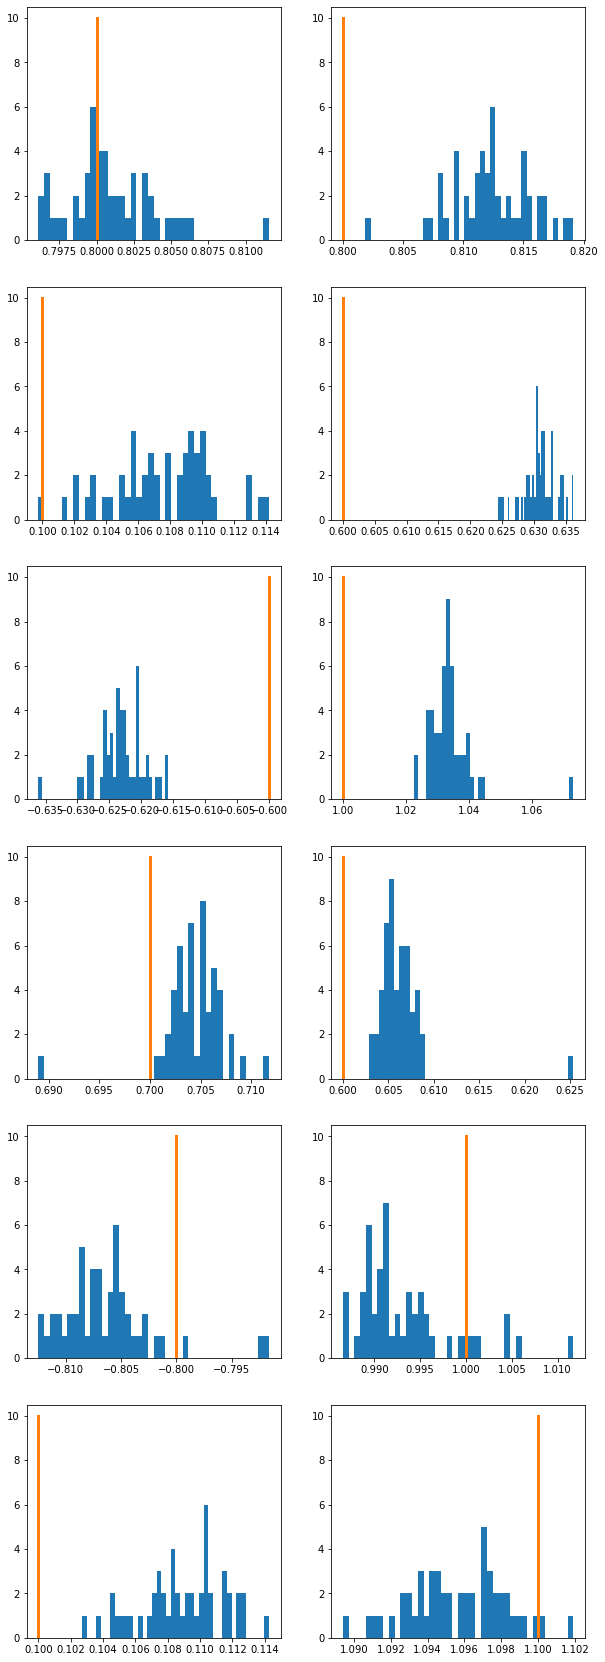

In [22]:
fig,ax = plt.subplots( ndim, 2, figsize=(2*5,ndim*5))

ymax = 10

for i in range(ndim) :
    
    ax[i][0].hist( all_mean[i], bins=40)
    ax[i][1].hist( all_rms[i], bins=40)
    
    ax[i][0].plot( (true_mu[i], true_mu[i]), (0,ymax), linewidth=3 )
    ax[i][1].plot( (true_sig[i], true_sig[i]), (0,ymax), linewidth=3 )

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

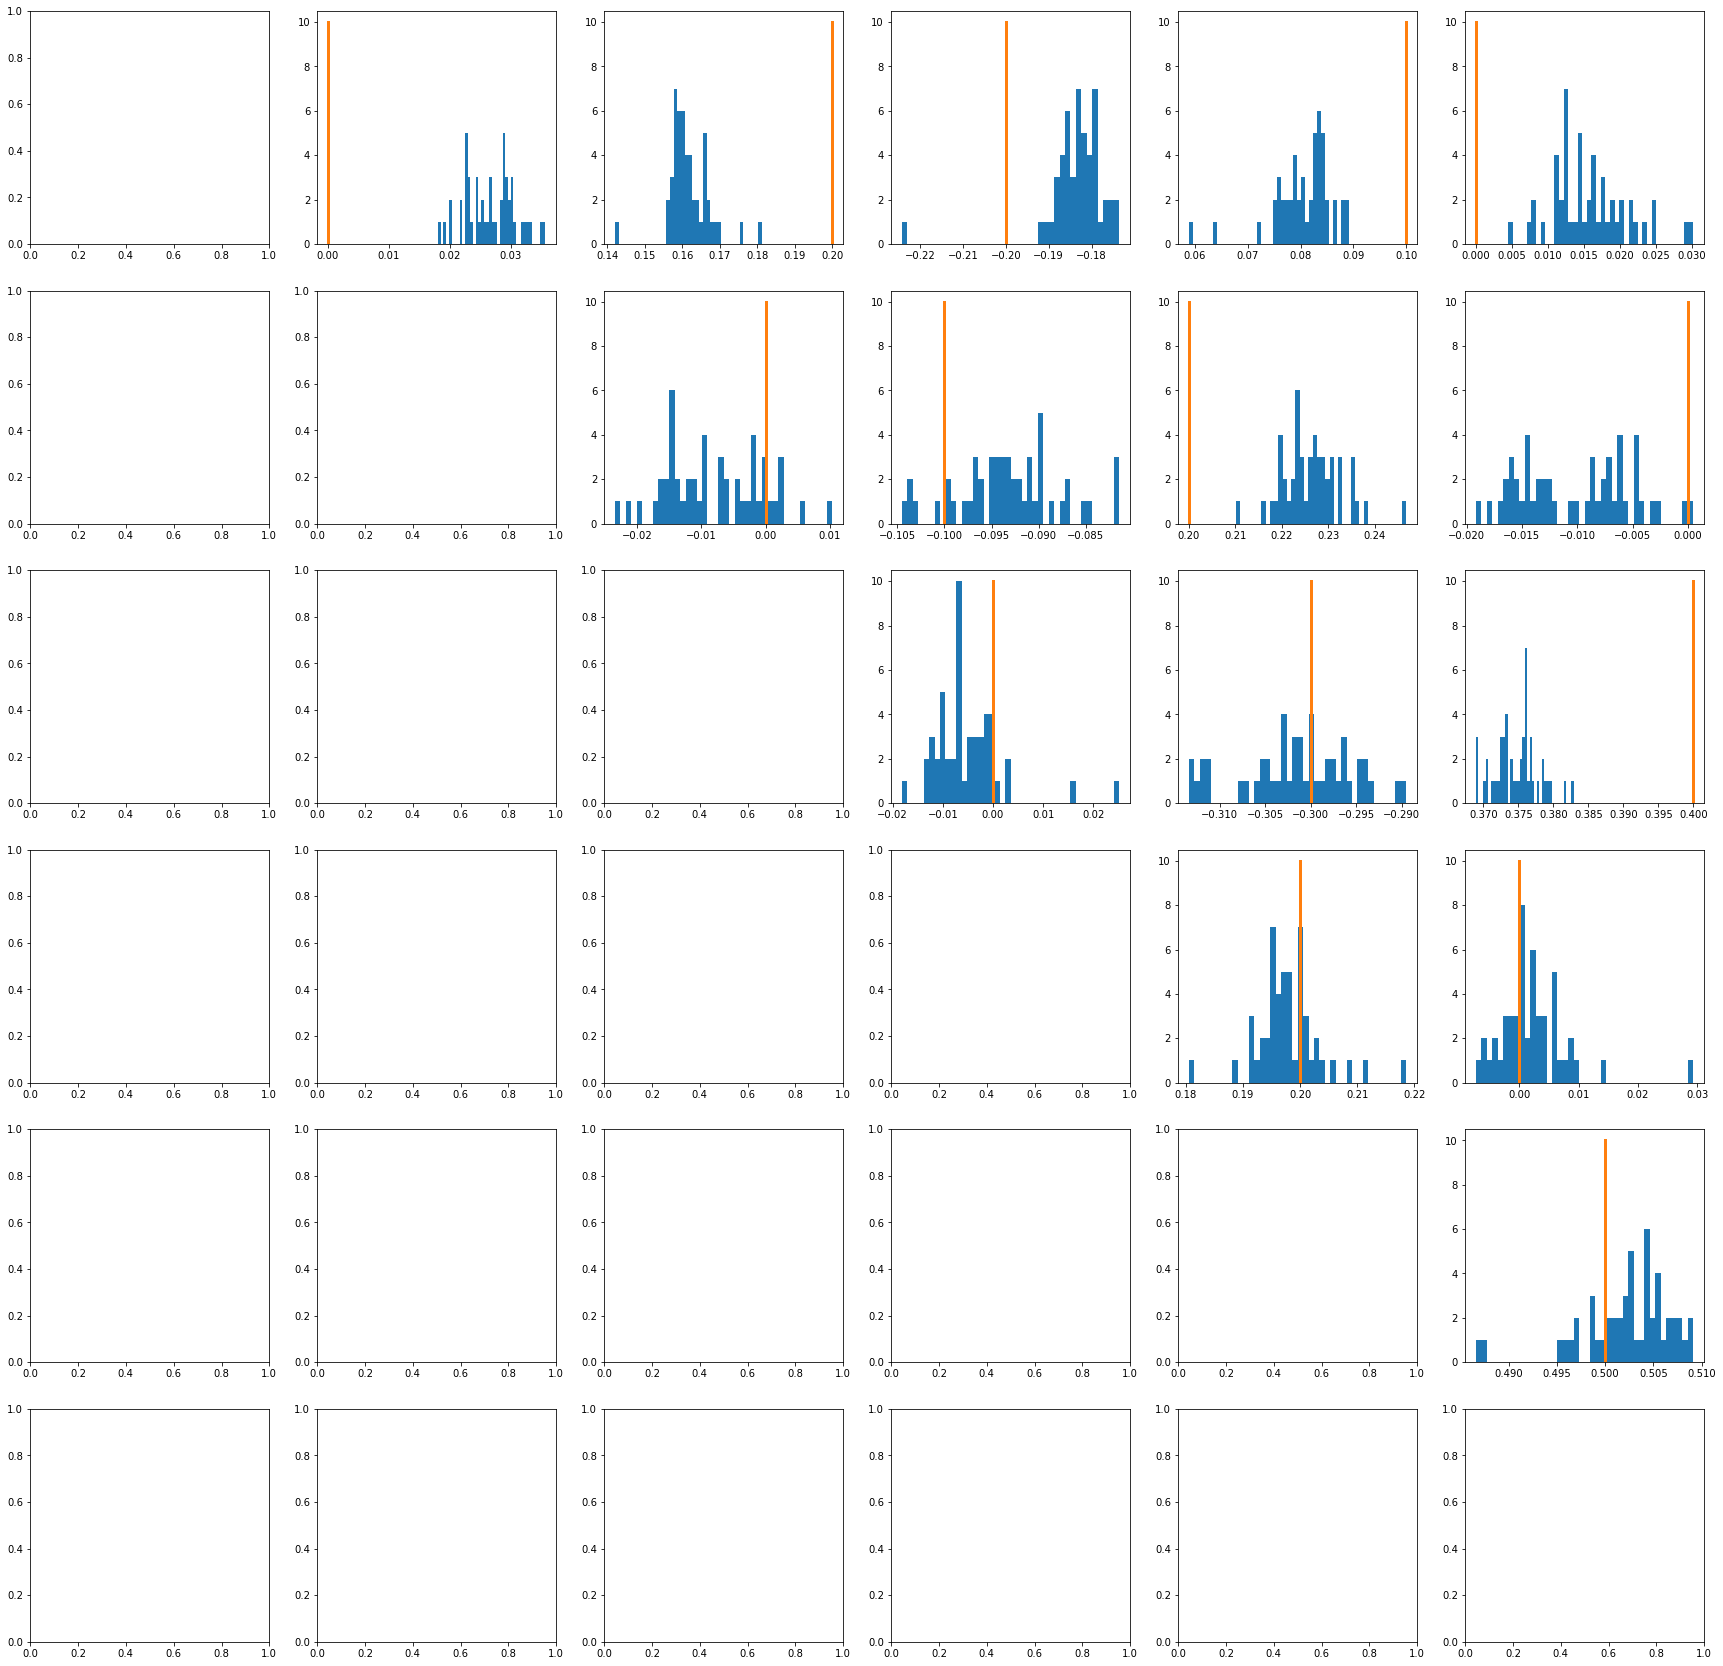

In [23]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5,ndim*5))

ymax = 10

for i in range(0,ndim-1) :
    
    for j in range(i+1,ndim) :
        
        k = ndim - j - 1
        
        ax[i][j].hist( all_rho[i,j], bins=40)
        
        ax[i][j].plot( (true_rho[i][k], true_rho[i][k]), (0, ymax), linewidth=3 )
    


plt.show

In [24]:
print('\n')

ave_mean = np.zeros( ndim )
rms_mean = np.zeros( ndim )

ave_cov = np.zeros( shape=(ndim,ndim) )
rms_cov = np.zeros( shape=(ndim,ndim) )


for fi in range(ndim) :
    
    ave_mean[fi] = np.mean( all_mean[fi] )
    ave_mean2 = np.mean( all_mean[fi]*all_mean[fi])
    rms_mean[fi] = np.sqrt( ave_mean2 - ave_mean[fi]*ave_mean[fi] )
    print("  feature %d  :  mean   ave %8.4f  (true %8.4f), rms %8.4f" % (fi, ave_mean[fi], true_mu[fi], rms_mean[fi] ))
    
print('\n')

for fi in range(ndim) :
    
    ave_rms = np.mean( all_rms[fi] )
    ave_rms2 = np.mean( all_rms[fi]*all_rms[fi])
    rms_rms = np.sqrt( ave_rms2 - ave_rms*ave_rms )
    print("  feature %d  :  RMS    ave %8.4f  (true %8.4f), rms %8.4f" % (fi, ave_rms, true_sig[fi], rms_rms ))
    
print('\n')

for fi1 in range(0,ndim-1) :
    for fi2 in range(fi1+1, ndim) :
        k = ndim - fi2 - 1
        ave_rho = np.mean( all_rho[fi1,fi2])
        ave_rho2 = np.mean( all_rho[fi1,fi2]*all_rho[fi1,fi2] )
        rms_rho = np.sqrt( ave_rho2 - ave_rho*ave_rho )
        print("  feature %d, %d  :  rho    ave %8.4f  (true %8.4f), rms %8.4f" % ( fi1, fi2, ave_rho, true_rho[fi1][k], rms_rho ))
        
print("\n")

for fi1 in range(0,ndim) :
    for fi2 in range(fi1,ndim) :
        ave_cov[fi1,fi2] = np.mean( all_cov[fi1][fi2] )
        ave_cov2 = np.mean( all_cov[fi1][fi2]*all_cov[fi1][fi2] )
        rms_cov[fi1,fi2] = np.sqrt( ave_cov2 - ave_cov[fi1,fi2]*ave_cov[fi1,fi2] )
        print("  feature %d, %d  :  cov    ave %8.4f  (true %8.4f), rms %8.4f" %
              (fi1, fi2, ave_cov[fi1,fi2], true_cov[fi1,fi2], rms_cov[fi1,fi2] ) )

print("\n")



  feature 0  :  mean   ave   0.8010  (true   0.8000), rms   0.0029
  feature 1  :  mean   ave   0.1075  (true   0.1000), rms   0.0032
  feature 2  :  mean   ave  -0.6232  (true  -0.6000), rms   0.0037
  feature 3  :  mean   ave   0.7044  (true   0.7000), rms   0.0030
  feature 4  :  mean   ave  -0.8063  (true  -0.8000), rms   0.0041
  feature 5  :  mean   ave   0.1089  (true   0.1000), rms   0.0026


  feature 0  :  RMS    ave   0.8123  (true   0.8000), rms   0.0033
  feature 1  :  RMS    ave   0.6308  (true   0.6000), rms   0.0026
  feature 2  :  RMS    ave   1.0338  (true   1.0000), rms   0.0073
  feature 3  :  RMS    ave   0.6063  (true   0.6000), rms   0.0031
  feature 4  :  RMS    ave   0.9935  (true   1.0000), rms   0.0052
  feature 5  :  RMS    ave   1.0956  (true   1.1000), rms   0.0026


  feature 0, 1  :  rho    ave   0.0267  (true   0.0000), rms   0.0041
  feature 0, 2  :  rho    ave   0.1618  (true   0.2000), rms   0.0056
  feature 0, 3  :  rho    ave  -0.1834  (true  -0.

## Save the simple direct calculation results for setting fit parameter ranges from RMS.

In [25]:
with open( '%s/simple-calc-results.npy' % input_dir, 'wb' ) as f :
    np.save( f, ave_mean )
    np.save( f, rms_mean )
    np.save( f, ave_cov )
    np.save( f, rms_cov )

In [26]:
if have_fits :
    
    for si in range( n_samples ) :
        
        for fi in range( 1,2 ) :
            print("  sample %3d :  mean%d   calc  %8.4f  fit %8.4f" % 
                  (si, fi, all_mean[fi,si], fit_results_mean_val[fi,si]))

  sample   0 :  mean1   calc    0.1058  fit   0.1058
  sample   1 :  mean1   calc    0.1033  fit   0.1033
  sample   2 :  mean1   calc    0.1054  fit   0.1054
  sample   3 :  mean1   calc    0.1095  fit   0.1096
  sample   4 :  mean1   calc    0.1080  fit   0.1080
  sample   5 :  mean1   calc    0.1069  fit   0.1069
  sample   6 :  mean1   calc    0.1067  fit   0.1067
  sample   7 :  mean1   calc    0.1060  fit   0.1060
  sample   8 :  mean1   calc    0.1021  fit   0.1021
  sample   9 :  mean1   calc    0.1128  fit   0.1128
  sample  10 :  mean1   calc    0.1100  fit   0.1100
  sample  11 :  mean1   calc    0.1106  fit   0.1106
  sample  12 :  mean1   calc    0.1100  fit   0.1098
  sample  13 :  mean1   calc    0.1142  fit   0.1142
  sample  14 :  mean1   calc    0.1086  fit   0.1086
  sample  15 :  mean1   calc    0.1070  fit   0.1070
  sample  16 :  mean1   calc    0.1051  fit   0.1051
  sample  17 :  mean1   calc    0.1073  fit   0.1073
  sample  18 :  mean1   calc    0.1089  fit   

   0 : x axis limits:  0.795, 0.812    y axis limits  0.792, 0.807
   1 : x axis limits:  0.099, 0.115    y axis limits  0.099, 0.115
   2 : x axis limits:  -0.637, -0.615    y axis limits  -0.629, -0.615
   3 : x axis limits:  0.688, 0.713    y axis limits  0.700, 0.709
   4 : x axis limits:  -0.814, -0.791    y axis limits  -0.814, -0.801
   5 : x axis limits:  0.102, 0.115    y axis limits  0.104, 0.115


<function matplotlib.pyplot.show(close=None, block=None)>

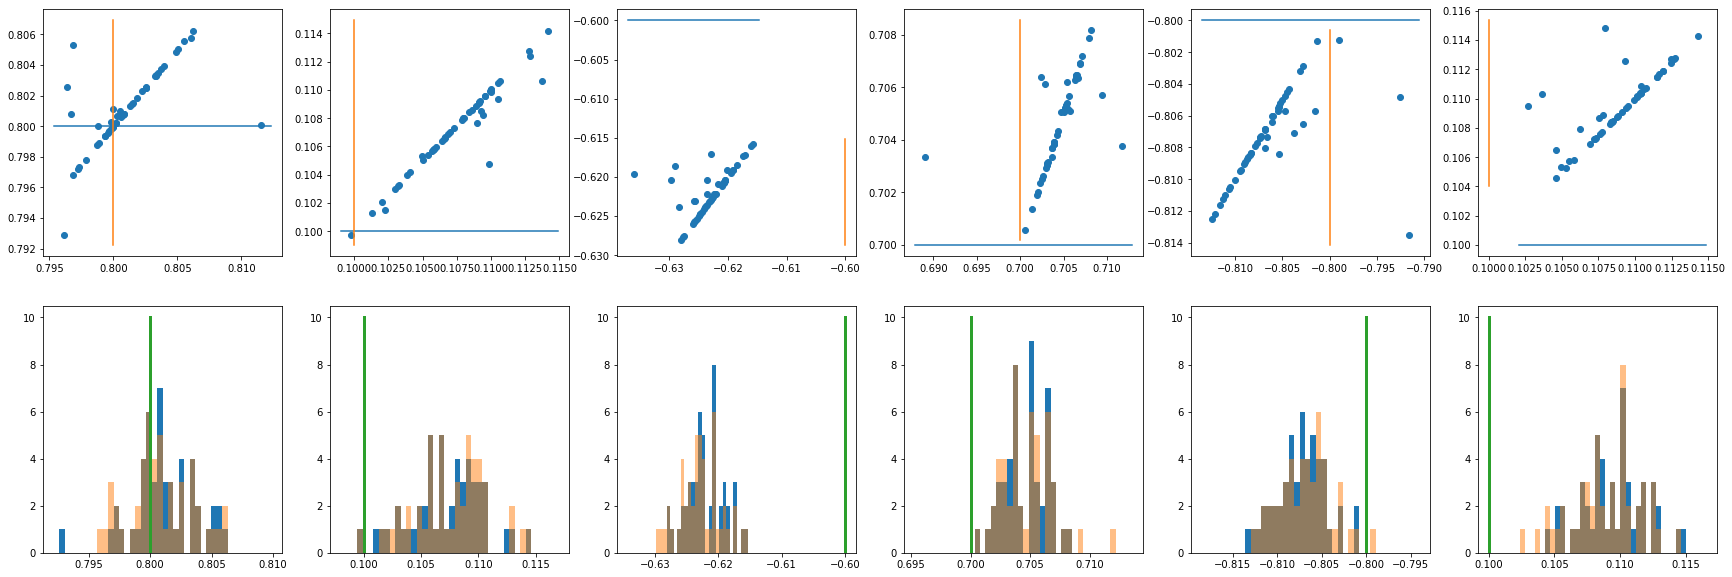

In [27]:
fig,ax = plt.subplots( 2, ndim, figsize=(5*ndim,5*2))

hbins=40
hmax = 10

for fi in range(ndim) :
    ax[0][fi].scatter( all_mean[fi,:], fit_results_mean_val[fi,:])
    xlow, xhigh = ax[0][fi].get_xlim()
    ylow, yhigh = ax[0][fi].get_ylim()
    print("  %2d : x axis limits:  %.3f, %.3f    y axis limits  %.3f, %.3f" % 
              (fi, xlow, xhigh, ylow, yhigh))
    ax[0][fi].plot( (xlow, xhigh), (true_mu[fi], true_mu[fi]))
    ax[0][fi].plot( (true_mu[fi], true_mu[fi]), (ylow, yhigh))
    

    ax[1][fi].hist( fit_results_mean_val[fi,:], bins=hbins, 
                   range=[ave_mean[fi]-3*rms_mean[fi], ave_mean[fi]+3*rms_mean[fi]])
    ax[1][fi].hist( all_mean[fi,:], bins=hbins, alpha=0.5,
                   range=[ave_mean[fi]-3*rms_mean[fi], ave_mean[fi]+3*rms_mean[fi]])
    ax[1][fi].plot( (true_mu[fi],true_mu[fi]),(0,hmax), linewidth=3)
    

plt.show

   0,  0 : x axis limits:  0.642, 0.672    y axis limits  0.637, 0.671
   0,  1 : x axis limits:  0.009, 0.019    y axis limits  0.009, 0.019
   0,  2 : x axis limits:  0.119, 0.160    y axis limits  0.131, 0.144
   0,  3 : x axis limits:  -0.116, -0.084    y axis limits  -0.094, -0.083
   0,  4 : x axis limits:  0.047, 0.073    y axis limits  0.059, 0.072
   0,  5 : x axis limits:  0.003, 0.028    y axis limits  0.006, 0.023
   1,  1 : x axis limits:  0.389, 0.405    y axis limits  0.389, 0.406
   1,  2 : x axis limits:  -0.017, 0.008    y axis limits  -0.014, 0.008
   1,  3 : x axis limits:  -0.040, -0.031    y axis limits  -0.041, -0.031
   1,  4 : x axis limits:  0.129, 0.159    y axis limits  0.130, 0.151
   1,  5 : x axis limits:  -0.014, 0.001    y axis limits  -0.014, 0.001
   2,  2 : x axis limits:  1.040, 1.157    y axis limits  1.043, 1.088
   2,  3 : x axis limits:  -0.013, 0.018    y axis limits  -0.009, 0.003
   2,  4 : x axis limits:  -0.330, -0.293    y axis limits  -0.

<function matplotlib.pyplot.show(close=None, block=None)>

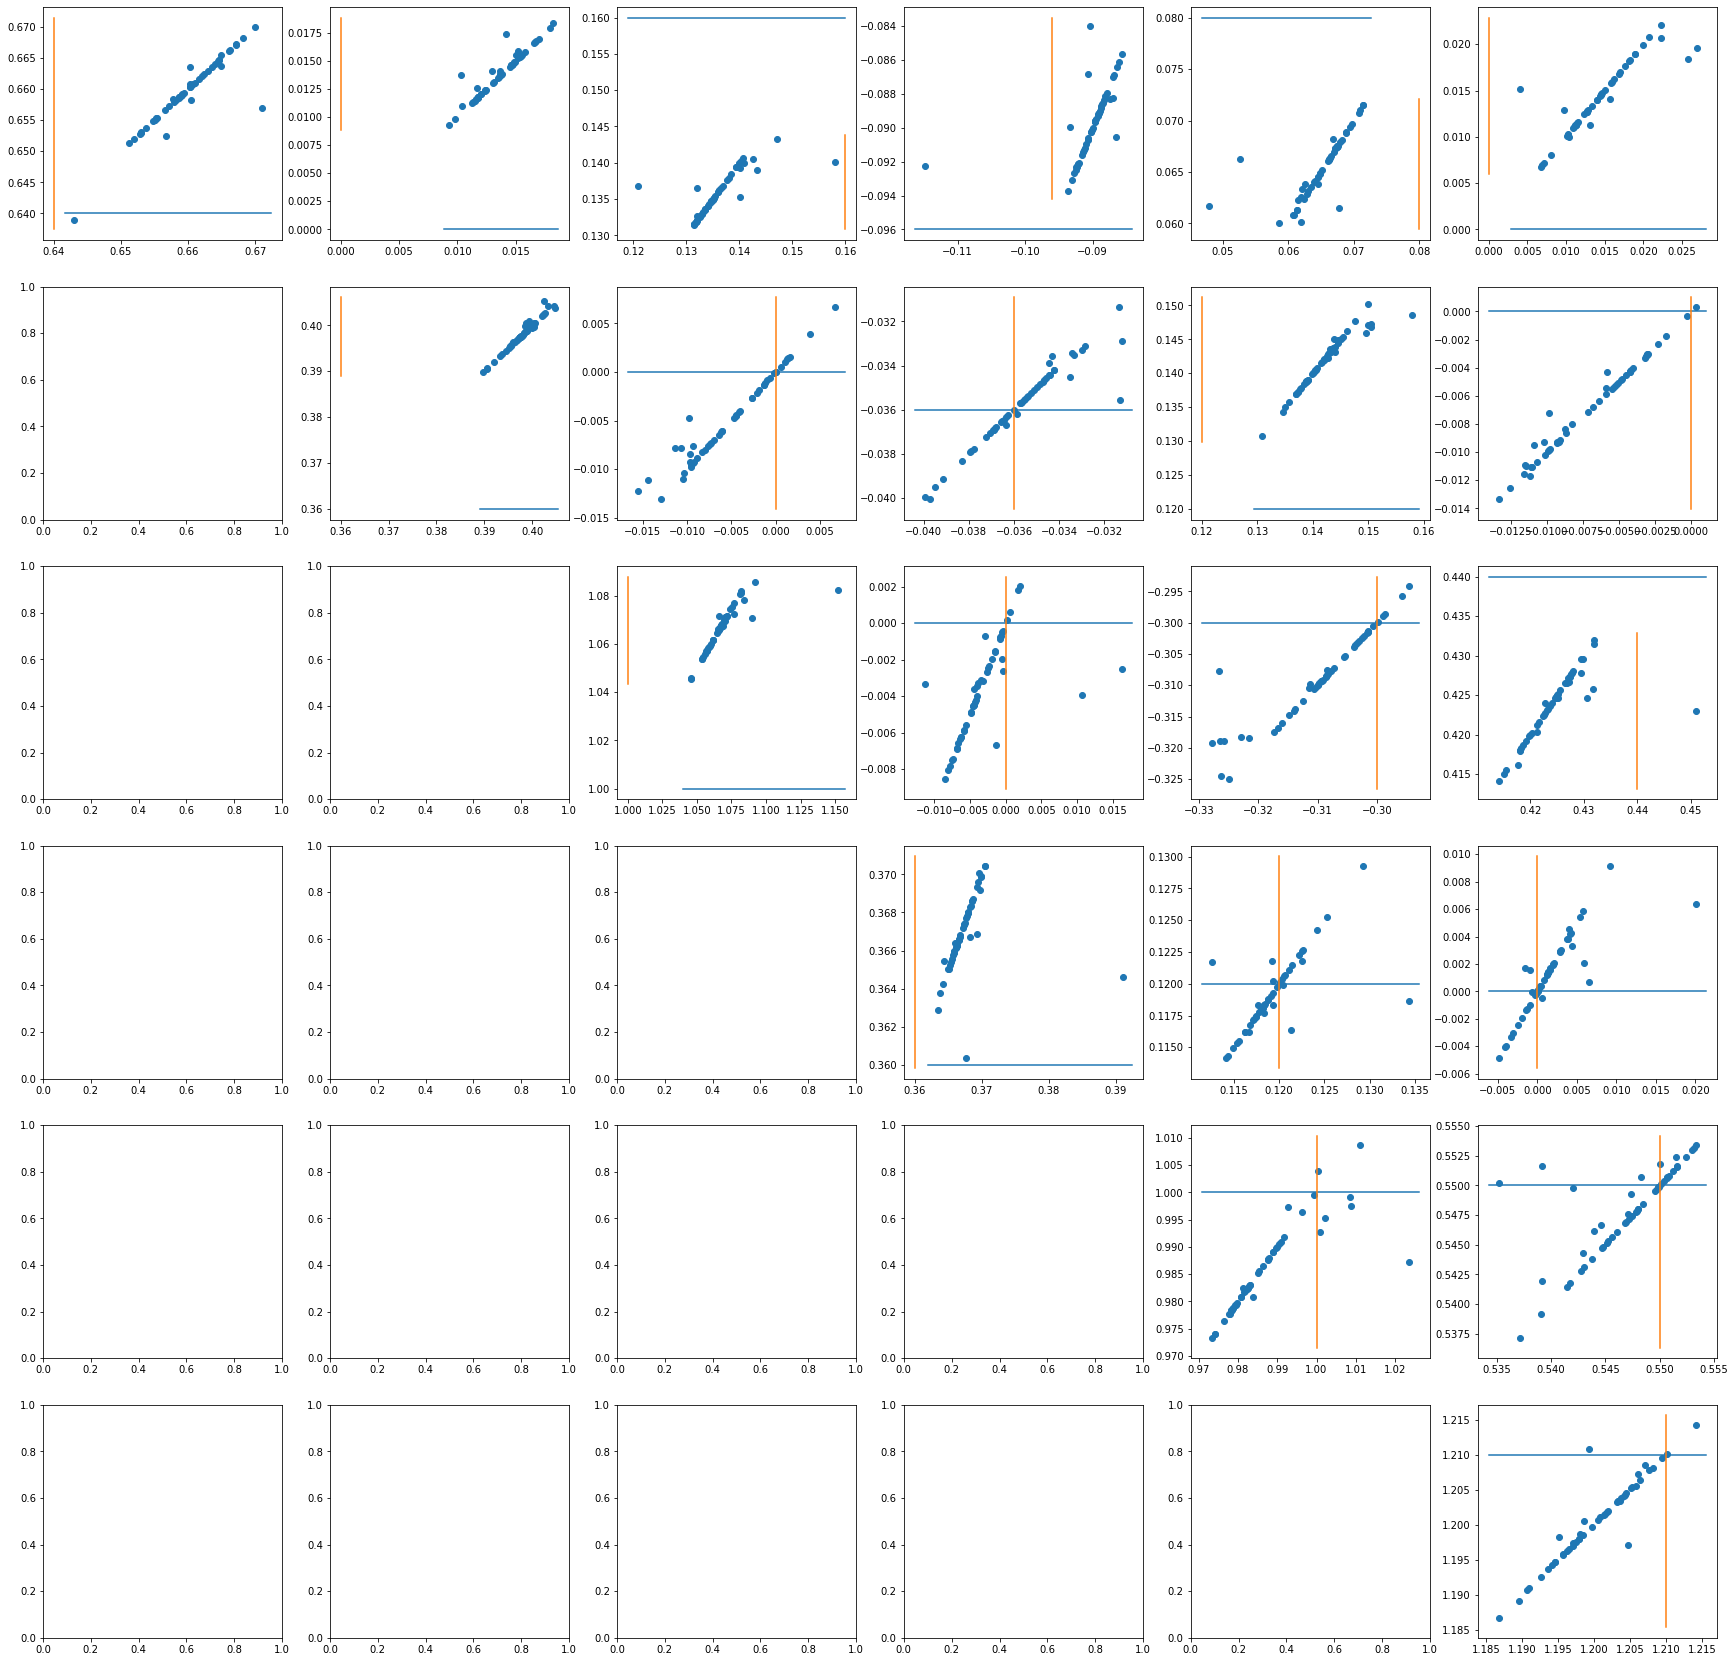

In [28]:
fig,ax = plt.subplots( ndim, ndim, figsize=(5*ndim,5*ndim))

for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        ax[fi1][fi2].scatter( all_cov[fi1,fi2,:], fit_results_cov_val[fi1,fi2,:])
        xlow, xhigh = ax[fi1][fi2].get_xlim()
        ylow, yhigh = ax[fi1][fi2].get_ylim()
        print("  %2d, %2d : x axis limits:  %.3f, %.3f    y axis limits  %.3f, %.3f" % 
              (fi1, fi2, xlow, xhigh, ylow, yhigh))
        ax[fi1][fi2].plot((xlow,xhigh),(true_cov[fi1][fi2], true_cov[fi1][fi2]))
        ax[fi1][fi2].plot((true_cov[fi1][fi2], true_cov[fi1][fi2]),(ylow,yhigh))

plt.show

   0,  0 : x axis limits:  0.642, 0.677    y axis limits  0.000, 7.350
   0,  1 : x axis limits:  0.007, 0.021    y axis limits  0.000, 6.300
   0,  2 : x axis limits:  0.119, 0.153    y axis limits  0.000, 7.350
   0,  3 : x axis limits:  -0.104, -0.077    y axis limits  0.000, 7.350
   0,  4 : x axis limits:  0.051, 0.079    y axis limits  0.000, 8.400
   0,  5 : x axis limits:  -0.001, 0.030    y axis limits  0.000, 6.300
   1,  1 : x axis limits:  0.387, 0.409    y axis limits  0.000, 6.300
   1,  2 : x axis limits:  -0.021, 0.011    y axis limits  0.000, 7.350
   1,  3 : x axis limits:  -0.042, -0.029    y axis limits  0.000, 5.250
   1,  4 : x axis limits:  0.126, 0.158    y axis limits  0.000, 6.300
   1,  5 : x axis limits:  -0.018, 0.004    y axis limits  0.000, 6.300
   2,  2 : x axis limits:  1.018, 1.119    y axis limits  0.000, 9.450
   2,  3 : x axis limits:  -0.018, 0.012    y axis limits  0.000, 6.300
   2,  4 : x axis limits:  -0.338, -0.282    y axis limits  0.000, 7.

<function matplotlib.pyplot.show(close=None, block=None)>

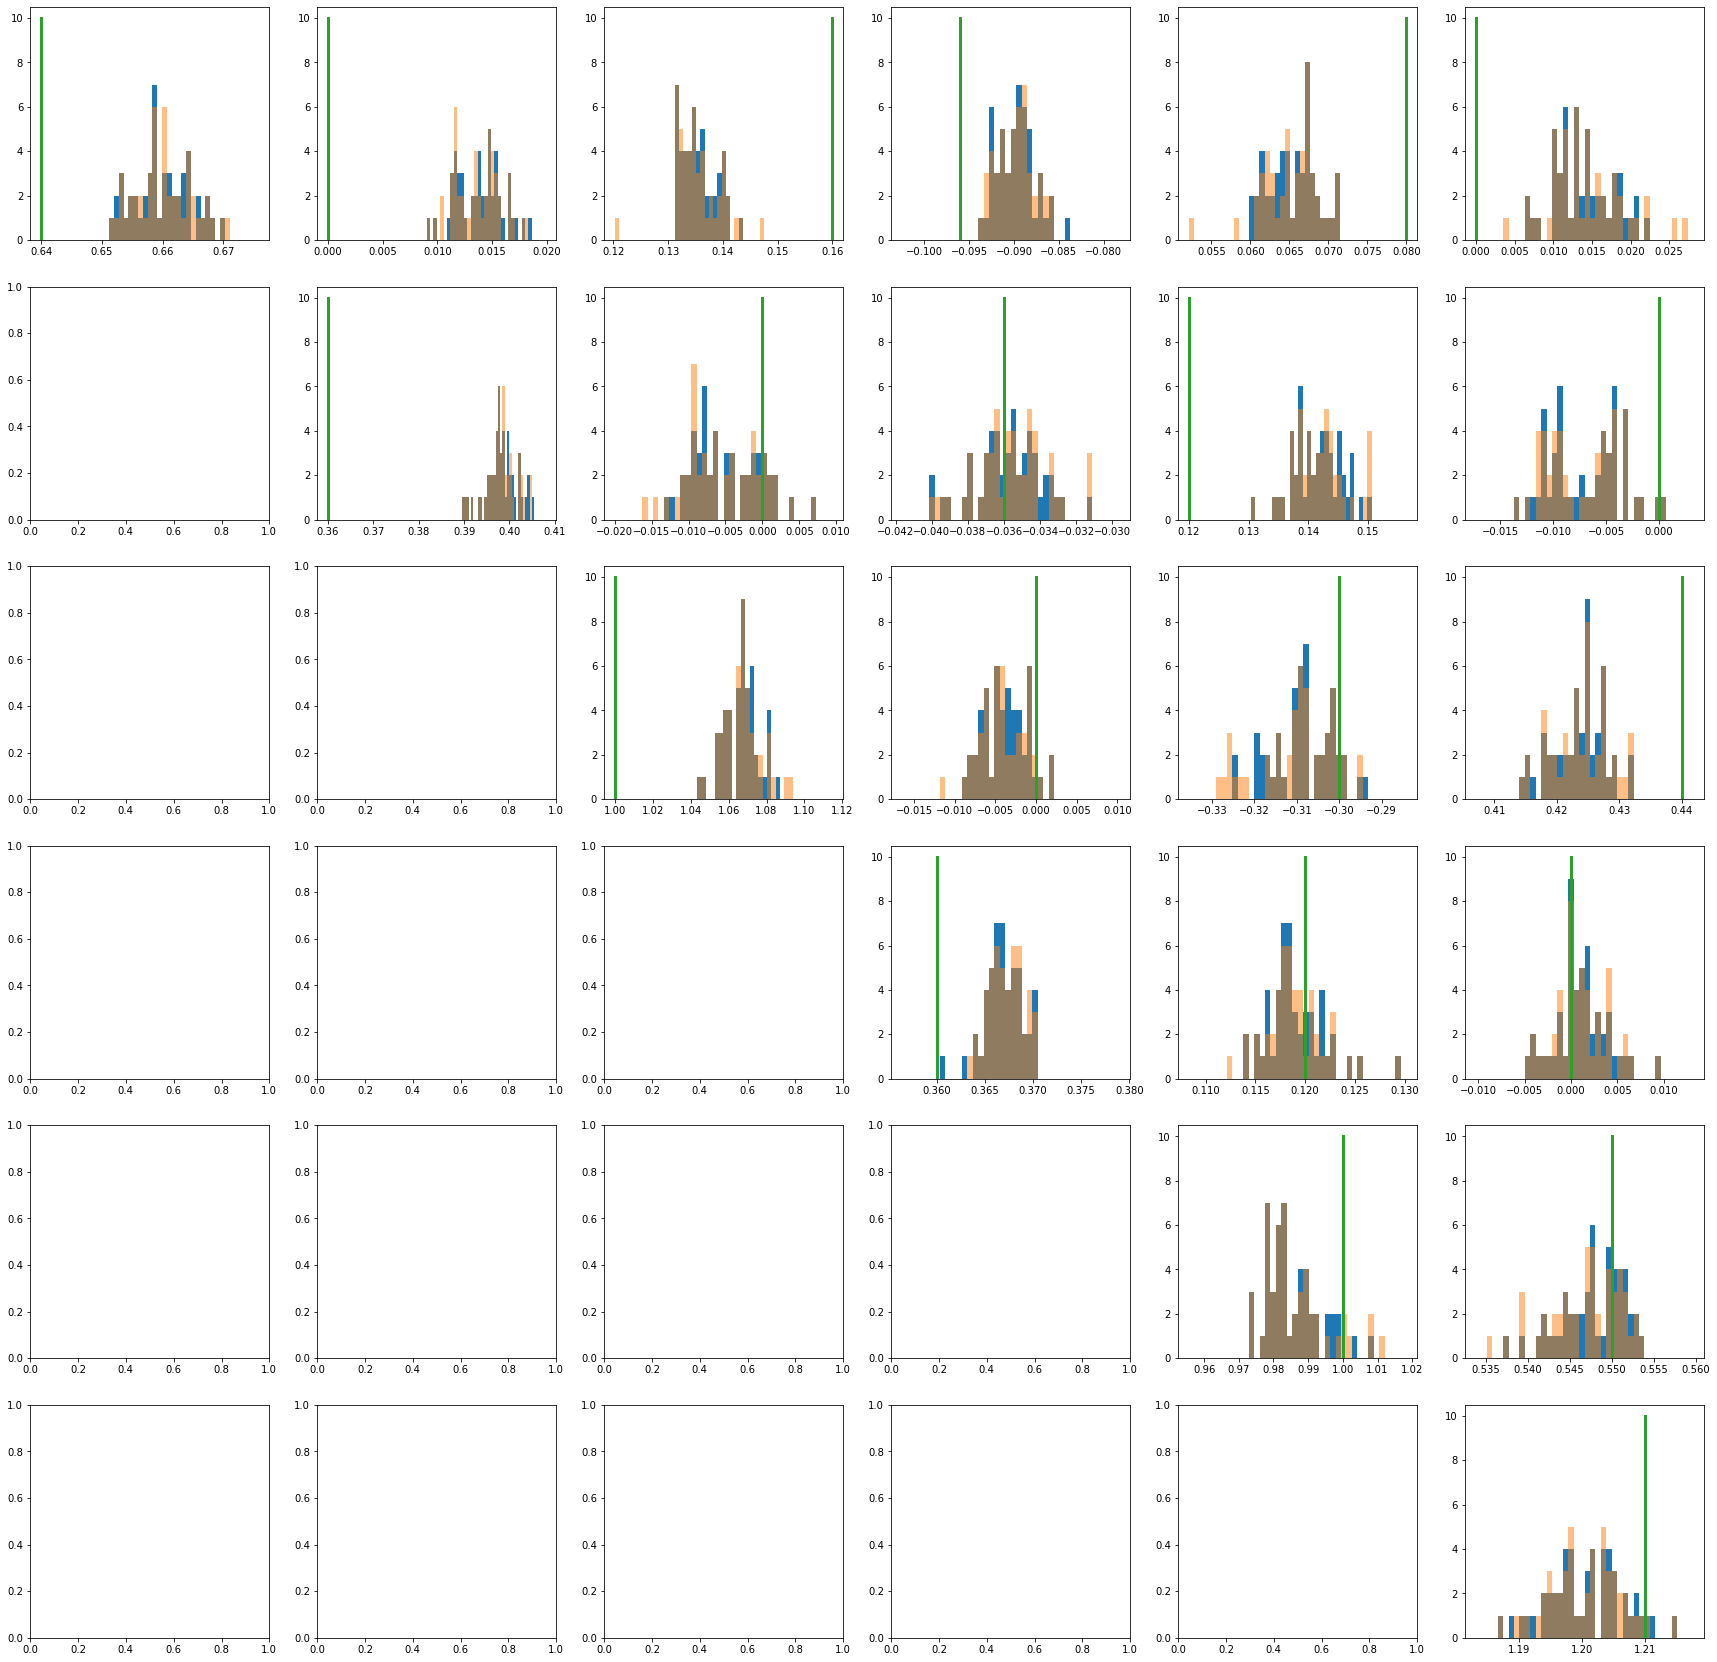

In [29]:
fig,ax = plt.subplots( ndim, ndim, figsize=(5*ndim,5*ndim))

hbins=40
hmax=10

for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        ax[fi1][fi2].hist( fit_results_cov_val[fi1,fi2,:], bins=hbins, 
                         range=[ave_cov[fi1,fi2]-3*rms_cov[fi1,fi2], ave_cov[fi1,fi2]+3*rms_cov[fi1][fi2]] )
        ax[fi1][fi2].hist( all_cov[fi1,fi2,:], bins=hbins, alpha=0.5,
                         range=[ave_cov[fi1,fi2]-3*rms_cov[fi1,fi2], ave_cov[fi1,fi2]+3*rms_cov[fi1][fi2]] )
        xlow, xhigh = ax[fi1][fi2].get_xlim()
        ylow, yhigh = ax[fi1][fi2].get_ylim()
        print("  %2d, %2d : x axis limits:  %.3f, %.3f    y axis limits  %.3f, %.3f" % 
              (fi1, fi2, xlow, xhigh, ylow, yhigh))

        ax[fi1][fi2].plot((true_cov[fi1][fi2], true_cov[fi1][fi2]),(0,hmax), linewidth=3)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

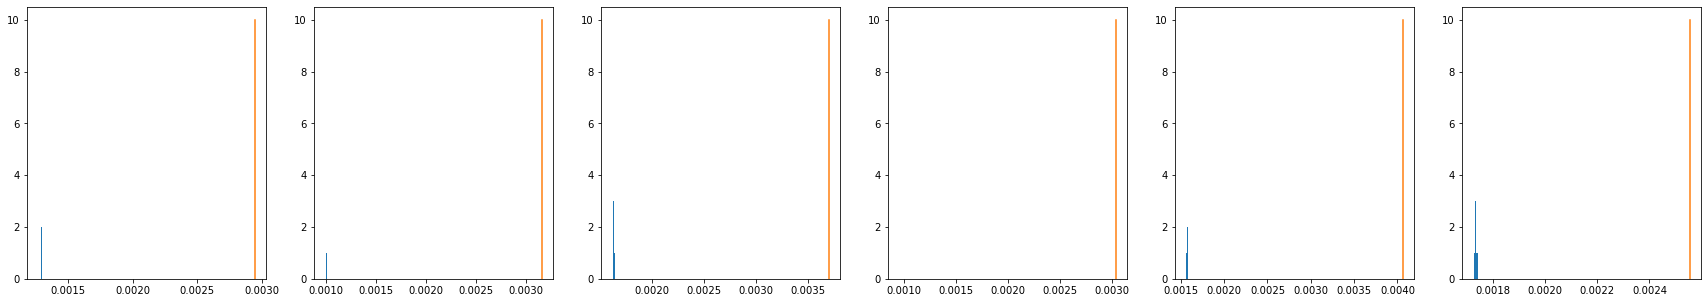

In [30]:
fig,ax = plt.subplots( 1, ndim, figsize=(5*ndim,5))

hbins = 40
hmax = 10

for fi in range(ndim) :
    ax[fi].hist( fit_results_mean_err[fi,:], bins=hbins )
    ax[fi].plot( (rms_mean[fi], rms_mean[fi]), (0,hmax) )
    
    
plt.show

## Bootstrap error compared with average fit error

In [31]:
for fi in range(ndim) :
    
    print("  feature %d mean:   rms bootstraps %8.4f,  ave fit err %8.4f    ratio  %8.2f"
         % (fi, rms_mean[fi], ave_fit_err_mean[fi], rms_mean[fi] / ave_fit_err_mean[fi] ))

  feature 0 mean:   rms bootstraps   0.0029,  ave fit err   0.0013    ratio      2.30
  feature 1 mean:   rms bootstraps   0.0032,  ave fit err   0.0010    ratio      3.17
  feature 2 mean:   rms bootstraps   0.0037,  ave fit err   0.0016    ratio      2.27
  feature 3 mean:   rms bootstraps   0.0030,  ave fit err   0.0010    ratio      3.18
  feature 4 mean:   rms bootstraps   0.0041,  ave fit err   0.0016    ratio      2.59
  feature 5 mean:   rms bootstraps   0.0026,  ave fit err   0.0017    ratio      1.48


## Look for outliers in feature coords and weights

In [38]:
for fi in range( ndim ) :
    
    print( "  feature %2d :  min %12f   max %12f " % ( fi, np.min(train_pts[:,fi]), np.max(train_pts[:,fi])) )

  feature  0 :  min    -5.030039   max     6.190336 
  feature  1 :  min    -3.483425   max     3.414853 
  feature  2 :  min    -6.016196   max     5.104850 
  feature  3 :  min    -3.777521   max     5.066930 
  feature  4 :  min    -7.399586   max     5.077774 
  feature  5 :  min    -7.141099   max     7.532398 


In [41]:
for si in range( n_samples ) :
    
    max_delta_mean = 0
    for fi in range(ndim) :
        delta = fit_results_mean_val[fi,si] - all_mean[fi,si] 
        if np.abs(delta) > max_delta_mean :
            max_delta_mean = delta
        
    print("  %3d : weight range  %12g  to %12f ,   max delta mean  %12f"
         % (si, all_weight_min[si], all_weight_max[si], max_delta_mean ))

    0 : weight range   7.58007e-07  to     2.375671 ,   max delta mean      0.000018
    1 : weight range   3.54623e-07  to     2.068924 ,   max delta mean     -0.000001
    2 : weight range   6.49038e-09  to     2.715964 ,   max delta mean      0.000010
    3 : weight range   4.60025e-09  to     3.142814 ,   max delta mean      0.000017
    4 : weight range   1.31011e-08  to     2.997869 ,   max delta mean     -0.000012
    5 : weight range   7.88613e-08  to     4.750905 ,   max delta mean      0.000012
    6 : weight range   1.10549e-07  to     6.669474 ,   max delta mean      0.000015
    7 : weight range   2.33857e-09  to     6.955889 ,   max delta mean     -0.000009
    8 : weight range   4.85612e-11  to    11.564352 ,   max delta mean     -0.000003
    9 : weight range   5.89724e-09  to     5.635138 ,   max delta mean      0.000021
   10 : weight range    1.5746e-10  to     4.509254 ,   max delta mean      0.000011
   11 : weight range   2.24331e-09  to    14.371634 ,   max delta

## Look deeper into bootstrap with an outlier

In [72]:
si = 35

fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, si)
            
with open(fname,'rb') as f :
            
    final_push_weights_scaled = np.load(f)

<function matplotlib.pyplot.show(close=None, block=None)>

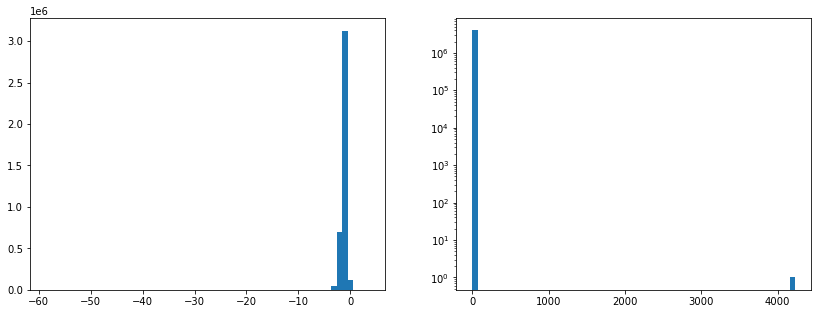

In [73]:
fig,ax = plt.subplots( 1, 2, figsize=(2*7,5))

hbins = 60
ax[0].hist( np.log10(final_push_weights_scaled), bins=hbins)
ax[1].hist( final_push_weights_scaled, bins=hbins)
ax[1].set_yscale('log')

plt.show

In [97]:
selection_mask = final_push_weights_scaled < 100
train_pts_sel = train_pts[ selection_mask ]
weights_sel = final_push_weights_scaled[ selection_mask ]

print(" number of events before selection  %d" % len(train_pts))
print(" number of events passing selection %d" % len(train_pts_sel))
print(" max weight before selection : %f" % np.max(final_push_weights_scaled))
print(" max weight passing selection: %f" % np.max(weights_sel))

 number of events before selection  4000000
 number of events passing selection 3999999
 max weight before selection : 4228.951916
 max weight passing selection: 12.511819


In [78]:
for fi in range( ndim ) :
    
    fit_mean = fit_results_mean_val[fi,si]
    mean_all_evts = all_mean[fi,si]
    mean_sel = ( np.sum( weights_sel * train_pts_sel[:,fi]) ) / ( np.sum( weights_sel ) )
    mean_diff = mean_sel - mean_all_evts
    print(" %2d :  fit mean  %10f   mean all  %10f   selected  %10f   diff %10f  fit diff %10f" % 
          ( fi, fit_mean, mean_all_evts, mean_sel, mean_diff, (mean_sel-fit_mean) ))

  0 :  fit mean    0.802554   mean all    0.796392   selected    0.802697   diff   0.006306  fit diff   0.000143
  1 :  fit mean    0.104757   mean all    0.109821   selected    0.104632   diff  -0.005190  fit diff  -0.000125
  2 :  fit mean   -0.618577   mean all   -0.629028   selected   -0.618337   diff   0.010692  fit diff   0.000241
  3 :  fit mean    0.703765   mean all    0.711762   selected    0.703571   diff  -0.008192  fit diff  -0.000194
  4 :  fit mean   -0.813529   mean all   -0.791607   selected   -0.814066   diff  -0.022459  fit diff  -0.000537
  5 :  fit mean    0.112537   mean all    0.109301   selected    0.112604   diff   0.003303  fit diff   0.000067


## Look at outlier point

In [98]:
train_pts_antisel = train_pts[ final_push_weights_scaled > 100 ]
train_pts_antisel.shape

(1, 6)

In [99]:
for fi in range( ndim ) :
    
    sigma = np.sqrt(ave_cov[fi,fi])
    
    print(" %2d :  val %10f   mean %10f   sigma %10f  diff/sigma %10f" %
          (fi, train_pts_antisel[0,fi], ave_mean[fi], sigma, (train_pts_antisel[0,fi]-ave_mean[fi])/sigma )
         )

  0 :  val   0.201112   mean   0.801001   sigma   0.812353  diff/sigma  -0.738459
  1 :  val   0.599742   mean   0.107476   sigma   0.630843  diff/sigma   0.780330
  2 :  val  -1.638369   mean  -0.623169   sigma   1.033785  diff/sigma  -0.982022
  3 :  val   1.485081   mean   0.704445   sigma   0.606346  diff/sigma   1.287443
  4 :  val   1.328635   mean  -0.806265   sigma   0.993465  diff/sigma   2.148943
  5 :  val  -0.202538   mean   0.108885   sigma   1.095613  diff/sigma  -0.284245


In [100]:
true_sig

array([0.8, 0.6, 1. , 0.6, 1. , 1.1])

## Calculate the true weights and compare with unfolding weights